In [83]:
import sys
import pdb
# sys.path.insert allows us to define paths from where we can import .py files
# sys.path.insert(0, 'D://Users//jvdputte//Documents//Work//Educational//5LSM0//jupyter_scripts//assets')
sys.path.insert(0, './mnist.py') 

import mnist
import numpy as np
import matplotlib.pyplot as plt

We will download and save the MNIST dataset. Also, we will create our 'handwritten' folder for the final question.

In [84]:
mnist.init()

Download complete.
Save complete.


Let's load the data and inspect its dimensions. Make sure you understand what each dimension represents.

In [85]:
X_train, y_train, X_test, y_test = mnist.load()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Lets plot some examples of the handwritten digits

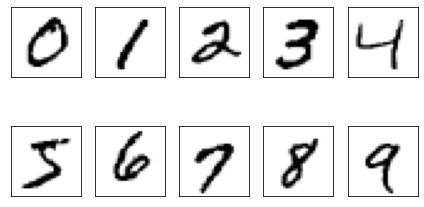

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Lets look at what different samples of the same digit looks like. You can change the label to look at other examples.

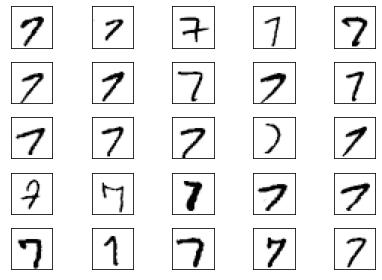

In [87]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28) # change the label to look at other digits
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

### Q1. Evaluate several examples of the digits. Name three data-augmentation operations that make sense for this data set.

<span style="color:red">1. Perspective Transformations: Flip, rotation, scale, crop, and translation.  
    2. Noise Injection: Adding the right amount of noise can enhance the learning capability due to the data distortion which can be overcame by neural network.  
    3. Kernel Filters: Sharpen or blur the image to reduce the effect of outliers and noise.</span>  
    Reference: https://towardsdatascience.com/image-augmentation-mastering-15-techniques-and-useful-functions-with-python-codes-44c3f8c1ea1f

If we look at the shape of the training data, we can see that the data is stored in vectorized form (The 28x28 pixel images are reshaped to a 1x784 array before storing). From the original 60.000 samples. The resulting shapes of the training data and training labels is what we expect. Performing sanity checks such as this is generally a good idea, it reduces the amount spent debugging when an inevitable bug shows up.

### Q2: Think of two other sanity checks you could perform (what expectations do we have about our data). Data can be ordinary images but also auxiliary information such as for example the age of a patient with accompanying CT scan.

<span style="color:red">1. Check for datatype mismatches, variations in how values are entered, and missing values. Effective downstream analysis requires consistency. For example, shape of images and values of pixel in our case.  
    2. Look for duplicate records and outliers. For example, not a number between 0 to 9 or too many data for only one number in our case.</span>  
    Reference: https://www.trifacta.com/blog/4-key-steps-to-sanity-checking-your-data/

## Multi-layer perceptron
In this section we are going to implement our own multi-layer perceptron, including backpropagation. Carefully read all the hints in the code. The supplementary file will elaborate more on the details of the algorithm. You have to implement the following things:

1. the weight matrix initalizations
2. one-hot encoding
3. the sigmoid function
4. the forward pass
5. the cross-entropy cost function
6. the function that predicts (it uses the forward pass function and chooses the most likely prediction)
7. the function that fits the model on the data (it consist of the forwards pass, backpropagation algorithm and L2-regularization)

Before you start, really take your time to think about how your model should look and behave. What should the dimensions be of my weight and bias matrices? Why do I apply an activation function? How does one-hot encoding work with cross-entropy? It helps to also intermediatly print the sizes or values of you matrices to debug and confirm your code is working. For this, we have provided so called "sanity check" cells below the class cell.


In [90]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, input_dim=786, n_hidden=30, n_classes=10,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

        # insert the proper dimensions for the initialization matrices. Use the class variables.
        self.b_h = np.random.normal(size=(n_hidden))
        self.b_out = np.random.normal(size=(n_classes))
        self.w_h = np.random.normal(size=(input_dim, n_hidden))
        self.w_out = np.random.normal(size=(n_hidden, n_classes))
                
    
    # the onehot function encodes labels into onehot representation e.g. with 3 labels, 0->[1,0,0], 1->[0,1,0], 2->[0,0,1]
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        # implement onehot encoding here. 
        onehot = np.zeros((len(y), n_classes), dtype=int)
        for i in range(len(y)):
            onehot[i][int(y[i])] = 1

        # HINT: We would like a n_samples x n_labels vector where each row
        # represents a sample vector with zeros everywhere except for position k, where index k equals the target value (0-9).
        
        return onehot

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        # implement sigmoid function here
        sigmoid_out = 1/(1+np.exp(-z))
        return sigmoid_out

    def _forward(self, X):
        """Compute forward propagation step"""
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]-> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        # using softmax func???
        # a_out = self._sigmoid(z_out)
        exps = np.exp(z_out-np.max(z_out, axis=1, keepdims=True))
        a_out = exps / np.sum(exps, axis=1, keepdims=True)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        # calculate the cross-entropy cost 
        cost = 0
        for i in range(np.shape(y_enc)[0]):
            for j in range(np.shape(y_enc)[1]):
                if y_enc[i][j] == 1:
                    cost -= np.log(output[i][j])
                else:
                    cost -= np.log(1-output[i][j])
        cost = cost / len(y_enc)
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        # implement prediction here
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.zeros(len(X), dtype=int)
        for i in range(len(y_pred)):
            y_pred[i] = np.argmax(a_out[i])
        
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        # create dictionary to keep track of training scores
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # convert y to one-hot encoding
        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            # this for loop takes care of the batching process. Every iteration several samples are fed through the network in one go.
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # calculate error vector of the output layer: sigma_out, [n_samples, n_classlabels]
                # 尚未搞明白除n的必要性，是否需要
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # calculate derivative of the sigmoid activation function:
                # sigmoid_derivative_h, [n_samples, n_hidden]
                sigmoid_derivative_h = np.dot(sigma_out, self.w_out.T)

                # Calculate the error term of the hidden layer: sigma_h, 
                #[n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = sigmoid_derivative_h * (a_h*(1-a_h))

                # Calculate the gradients of the weights in the hidden layer
                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)

                # calculate gradients of the biases in the hidden layer (freebee)
                grad_b_h = np.sum(sigma_h, axis=0)

                # Calculate the gradients of the weights in the output layer
                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                
                # calculate the gradient of the biases in the output layer
                grad_b_out = np.sum(sigma_out, axis=0)

                # L2-regularization and weight updates (bias is not regularized)
                delta_w_h = grad_w_h + 2*self.l2*self.w_h
                delta_b_h = grad_b_h 
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = grad_w_out + 2*self.l2*self.w_out
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r' + '{}/{} | Cost: {:.1f} | Train/Valid Acc.: {:.2f}%/{:.2f}% '.format(i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

! SANITY CHECK AREA ! - You can check here wether your functions work as intended

In [91]:
test_model = NeuralNetMLP()

# Onehot encoding
labels = np.array([0., 3., 4., 5., 9., 4., 0.])
n_classes = 10
onehot_vectors = test_model._onehot(labels, n_classes)
print(onehot_vectors)

[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


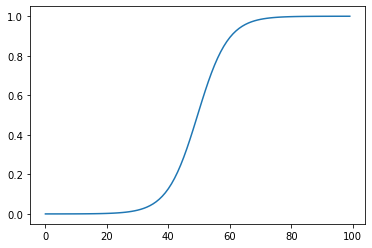

In [92]:
# Sigmoid activation
x = np.linspace(-10, 10, 100)
out = test_model._sigmoid(x)
plt.plot(out)
plt.show()

In [93]:
# Forward call
samples = np.random.normal(size=(50, 786)) # fake samples
z_h, a_h, z_out, a_out = test_model._forward(samples)
print(z_h.shape, a_h.shape, z_out.shape, a_out.shape)

(50, 30) (50, 30) (50, 10) (50, 10)


In [94]:
# Loss (cost function)
outputs = np.random.rand(7, 10)
loss = test_model._compute_cost(onehot_vectors, outputs)
print(loss) # should appr. be between 5 and 15

9.456184356352221


In [95]:
# Predictions - the predictions make no sense at this point of course!
predictions = test_model.predict(samples)
print(predictions)

[9 9 6 6 9 9 7 9 7 9 7 9 9 7 9 9 9 7 7 9 9 9 9 9 9 9 9 9 9 7 7 6 9 8 9 7 7
 7 9 4 9 7 9 7 7 9 7 4 7 7]


Lets initialize the network and feed it training and validation data (55000 samples are used for training, remaining 5000 samples are used for validation).
### Q3. Why do we define a validation set even though we already have a test set of unseen samples? Explain your answer.
<span style="color:red">1. Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.  
    2. Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.</span>  
    Reference: https://machinelearningmastery.com/difference-test-validation-datasets/

In [96]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=20, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

<ipython-input-90-317896af1132>:81: RuntimeWarning: overflow encountered in exp
  sigmoid_out = 1/(1+np.exp(-z))
<ipython-input-90-317896af1132>:268: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
<ipython-input-90-317896af1132>:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecatio

Lets plot the cost and the training/validation accuracy for 20 epochs. We can see the cost is decreasing and accuracy of both the training and validation is going up.

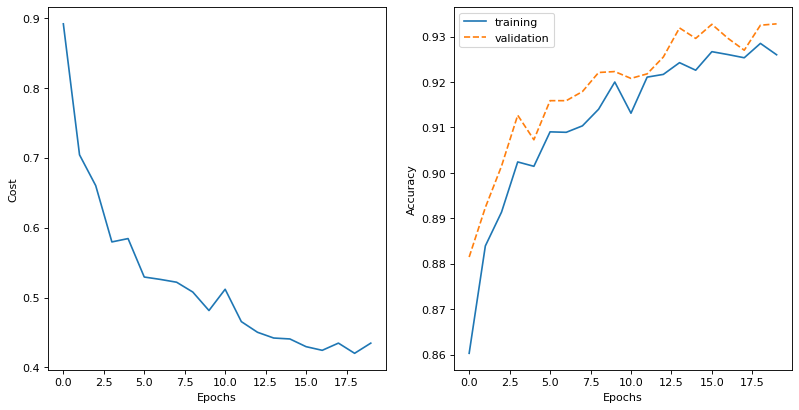

In [97]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()


## Q4. The validation accuracy is higher than the training accuracy. What does this say about the quality of the model?
<span style="color:red"> Usually, the training data hyperparameters would be tuned well and that will result in a better prediction in the validation data; it is good phenomenon in this case. However, in our case, there is no fine-tuning after applying validation. Therefore, we cannot tell the quality of the model is absolutely good or not. From the perspective of data itself, it is probably because the validation data has less complexity, which causes the higher accuracy than training accuracy.</span>  
Reference: https://www.quora.com/Can-validation-accuracy-be-higher-than-training-accuracy 

In [98]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=200, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=123)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

<ipython-input-90-317896af1132>:81: RuntimeWarning: overflow encountered in exp
  sigmoid_out = 1/(1+np.exp(-z))
<ipython-input-90-317896af1132>:268: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
<ipython-input-90-317896af1132>:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecatio

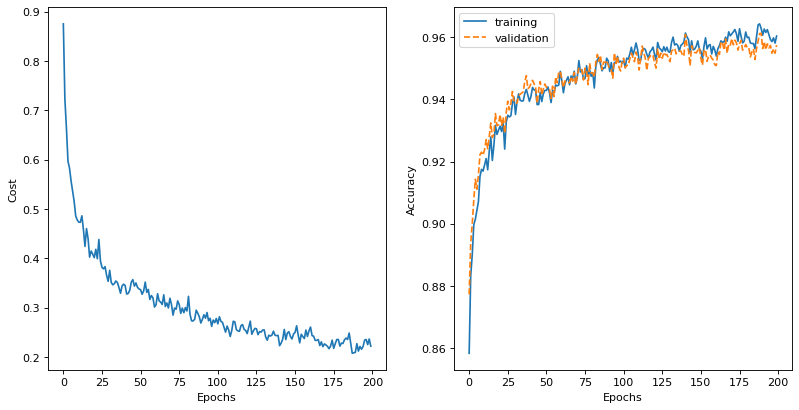

In [99]:
fig=plt.figure(figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

## Q5. The neural network is getting pretty good results on the data. What changes in the architecture or training procedure could you change in order to improve on the results further?

<span style="color:red">1. Architecture: add CNN layer(s) for feature extraction / increase nodes or number of hidden layers  
    2. Training Procedure: dropout for preventing overfitting / increase data / early stopping / cross-validation / hyperparameters tuning / apply regularization</span>

## Q6. We used accuracy as our evaluation metric but there are many other metrics we can evaluate on. Explain the possible pitfalls of only relying on accuracy with an example. Suggest other metrics we can use to see if our model generalized well and explain what the metric evaluates on.

<span style="color:red">The possible pitfall of classification accuracy is that the cost of misclassification of the minor class samples are very high. It only works well if there are equal number of samples belonging to each class. For example, there are 90% samples of class A and 10% samples of class B. The model can easily get 90% training accuracy by predicting samples belonging to class A. However, when we apply a test dataset with 50% samples of class B, then the accuracy drops dramatically due to the poor ability to recognize samples of class B.  
    Logarithmic loss is better than classification accuracy for the classifier in general. It works with penalising the false classifications; thus, it works well for multi-class classification like our case.</span>  
    Reference: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

## Q7. We are now going to run inference with our own handwritten images. Create three replicas of MNIST digits (by using e.g. paint) and show what your model predicts.   

Put your png images in the 'handwritten/' folder. You can simply use paint to write on a 28x28 canvas. Try to match the images as closely to MNIST-style as possible. 

For information on MNIST: http://yann.lecun.com/exdb/mnist/ 

Matplotlib shows the images black on white but the images are actually <b>white on black!</b>

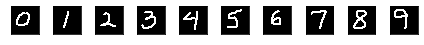

In [100]:
X_hw = mnist.handwritten()  # should be (N, 28, 28)

# Print handwritten digits
fig, ax = plt.subplots(nrows=1, ncols=X_hw.shape[0], sharex=True, sharey=True,)
ax = ax.flatten()
for i in range((X_hw.shape[0])):
    ax[i].imshow(X_hw[i,...], cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [109]:
# Run inference here and present predictions.
img_hw = abs(np.ceil(X_hw*255)-255).astype(int)    #color flipping
# First reshape numpy array as our training data
img_hw = img_hw.reshape(10,-1)
# Make predictions and present results
predictions_hw = nn.predict(img_hw)
print("The prediction result for handwritten data is", predictions_hw)
acc_hw = 0
for i in range(len(img_hw)):
    if predictions_hw[i]==i:
        acc_hw += 1
print("The accuracy for handwritten data is", acc_hw*10, "%")

The prediction result for handwritten data is [9 1 2 3 9 5 4 2 8 3]
The accuracy for handwritten data is 50 %


<ipython-input-90-317896af1132>:81: RuntimeWarning: overflow encountered in exp
  sigmoid_out = 1/(1+np.exp(-z))
